In [1]:
!pip install pandas numpy Pillow matplotlib scikit-learn seaborn torch torchvision

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import glob
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
from collections import defaultdict

# Путь к датасету
DATASET_DIR = "dataset"

# Константы
IMAGE_SIZE = (224, 224)  # Размер изображений для модели
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 20
EARLY_STOPPING_PATIENCE = 5  # Количество эпох для терпения early stopping
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)  # Для воспроизводимости

# Загрузка всех аннотаций в один DataFrame
def load_annotations(dataset_dir):
    """Загружает все аннотации из CSV файлов в один DataFrame."""
    annotations = []
    for csv_file in os.listdir(dataset_dir):
        if csv_file.endswith(".csv"):
            csv_path = os.path.join(dataset_dir, csv_file)
            df = pd.read_csv(csv_path)
            df["filename"] = csv_file.replace(".csv", ".jpg")  # Добавляем имя файла изображения
            annotations.append(df)
    return pd.concat(annotations, ignore_index=True)

In [3]:
# Загрузка данных
annotations_df = load_annotations(DATASET_DIR)
print(f"Загружено аннотаций: {len(annotations_df)}")

Загружено аннотаций: 27022


In [4]:
def custom_collate_fn(batch):
    """
    Обрабатывает батч данных с переменным количеством bounding boxes.
    Возвращает:
    - images: Тензор изображений (batch_size, channels, height, width).
    - boxes: Список тензоров bounding boxes для каждого изображения.
    """
    images = []
    boxes = []

    for image, box in batch:
        images.append(image)
        boxes.append(box)

    # Объединяем изображения в один тензор
    images = torch.stack(images, dim=0)

    # Возвращаем изображения и список тензоров bounding boxes
    return images, boxes

In [5]:
class LazyObjectDetectionDataset(Dataset):
    def __init__(self, annotations_df, dataset_dir, image_size=(224, 224), transforms=None):
        self.annotations_df = annotations_df
        self.dataset_dir = dataset_dir
        self.image_size = image_size
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        # Получаем информацию о текущем изображении
        row = self.annotations_df.iloc[idx]
        image_path = os.path.join(self.dataset_dir, row["filename"])
        image = Image.open(image_path).convert("RGB")  # Загружаем изображение

        # Получаем bounding boxes и классы
        boxes = []
        for _, box_row in self.annotations_df[self.annotations_df["filename"] == row["filename"]].iterrows():
            class_id = 0 if box_row["class"] == "US2" else 1  # Преобразуем класс в числовой формат
            xmin, ymin, xmax, ymax = box_row["xmin"], box_row["ymin"], box_row["xmax"], box_row["ymax"]
            boxes.append([class_id, xmin, ymin, xmax, ymax])

        # Нормализуем bounding boxes
        boxes = torch.tensor(boxes, dtype=torch.float32)
        boxes[:, 1:] /= torch.tensor([image.width, image.height, image.width, image.height])

        # Применяем трансформации к изображению
        image = image.resize(self.image_size)
        if self.transforms:
            image = self.transforms(image)

        return image, boxes

In [6]:
# Аугментация и нормализация
data_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet statistics
])

# Разделение данных на тренировочную, валидационную и тестовую выборки
train_df, val_test_df = train_test_split(annotations_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.33, random_state=42)

# Создание датасетов
train_dataset = LazyObjectDetectionDataset(train_df, DATASET_DIR, transforms=data_transforms)
val_dataset = LazyObjectDetectionDataset(val_df, DATASET_DIR, transforms=data_transforms)
test_dataset = LazyObjectDetectionDataset(test_df, DATASET_DIR, transforms=data_transforms)

# Создание DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=custom_collate_fn  # Используем нашу функцию
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=custom_collate_fn  # Используем нашу функцию
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=custom_collate_fn  # Используем нашу функцию
)

In [31]:
def train_one_epoch(model, optimizer, criterion, data_loader, epoch):
    model.train()
    epoch_loss = 0.0
    for images, boxes_list in data_loader:
        optimizer.zero_grad()

        # Передаем изображения в модель
        outputs = model(images)

        # Вычисляем потери для каждого изображения в батче
        loss = criterion(outputs, boxes_list)

        # Обратное распространение и обновление весов
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

    epoch_loss /= len(data_loader.dataset)
    print(f"Epoch {epoch + 1}: Train Loss: {epoch_loss:.4f}")
    return epoch_loss


# Функция потерь
def custom_loss(outputs, targets):
    """
    Custom loss function for object detection.
    Handles varying number of objects in each image.
    """
    loss = 0.0
    for i in range(outputs.size(0)):  # Iterate over batch
        output = outputs[i]  # predictions for single image
        target = targets[i]  # GT for single image

        # Remove padding/empty targets (all zeros)
        target = target[torch.any(target != 0, dim=1)]  # remove zero rows

        if target.nelement() == 0:  # No objects in target
            loss += torch.sum(output**2) * 0.1  # penalize predictions
            continue

        # Ensure output and target have the same number of objects
        num_targets = target.size(0)
        num_outputs = output.size(0)

        if num_outputs < num_targets:
            # Pad output with zeros if it has fewer objects than target
            padding = torch.zeros((num_targets - num_outputs, 5), device=output.device)
            output = torch.cat([output, padding], dim=0)
        elif num_outputs > num_targets:
            # Truncate output if it has more objects than target
            output = output[:num_targets]

        # Calculate L1 loss (absolute error) for bounding box coordinates
        l1_loss = nn.L1Loss()(output[:, 1:], target[:, 1:])

        # Calculate binary cross entropy loss for class probabilities
        bce_loss = nn.BCEWithLogitsLoss()(output[:, 0], target[:, 0])

        # Combine the losses
        loss += l1_loss + bce_loss

    return loss / outputs.size(0)  # Average for the batch


# Early stopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta

    def __call__(self, val_loss, model, model_path='checkpoint.pth'):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, model_path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), model_path)
        self.val_loss_min = val_loss


# Визуализация
def visualize_predictions(model, dataset, num_images=5):
    model.eval()
    indices = np.random.choice(len(dataset), num_images, replace=False)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i, idx in enumerate(indices):
        image, target_boxes = dataset[idx]
        image = image.unsqueeze(0)  # Добавляем размерность батча

        with torch.no_grad():
            predictions = model(image)

        # Remove batch dimension, now predictions is num_boxes x 5
        predictions = predictions[0]


        # Denormalize and convert to numpy for visualization.  Clamp to [0, 1]

        predicted_boxes = predictions[:, 1:].clone()
        predicted_boxes = predicted_boxes.clamp(0, 1) # Values must be in the range [0,1]
        predicted_boxes *= torch.tensor([dataset.image_size[0], dataset.image_size[1], dataset.image_size[0], dataset.image_size[1]])
        predicted_boxes = predicted_boxes.cpu().numpy()

        image = image.squeeze(0).permute(1, 2, 0).numpy() #Back to HWC
        image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) #Unnormalize
        image = np.clip(image, 0, 1)

        ax = axes[i]
        ax.imshow(image)
        ax.set_title("Prediction")
        ax.axis('off')

        # Overlay bounding boxes
        for box in predicted_boxes:
            class_prob = predictions[0][0].item()
            xmin, ymin, xmax, ymax = box.astype(int)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 fill=False, edgecolor='red', linewidth=1)
            ax.add_patch(rect)
            #ax.text(xmin, ymin - 2, f"Class: {class_prob:.2f}", color='red') #Add the probablity on the bounding box

    plt.show()

def evaluate_model(model, data_loader):
    """Evaluates the model and prints confusion matrix and metrics."""
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for images, boxes_list in data_loader:
            outputs = model(images)

            # Обрабатываем каждое изображение в батче
            for i, boxes in enumerate(boxes_list):
                output = outputs[i]  # Предсказания для текущего изображения
                target = boxes  # Целевые bounding boxes

                # Удаляем пустые целевые объекты (все нули)
                target = target[torch.any(target != 0, dim=1)]

                # Если на изображении нет объектов, пропускаем его
                if target.nelement() == 0:
                    continue

                # Выравниваем количество предсказанных и целевых объектов
                num_targets = target.size(0)
                num_outputs = output.size(0)

                if num_outputs < num_targets:
                    # Если предсказаний меньше, чем целевых объектов, дополняем нулями
                    padding = torch.zeros((num_targets - num_outputs, 5), device=output.device)
                    output = torch.cat([output, padding], dim=0)
                elif num_outputs > num_targets:
                    # Если предсказаний больше, чем целевых объектов, обрезаем лишние
                    output = output[:num_targets]

                # Извлекаем предсказанные классы и целевые классы
                predicted_classes = torch.round(output[:, 0]).cpu().numpy()  # Предсказанные классы
                target_classes = target[:, 0].cpu().numpy()  # Целевые классы

                # Сохраняем результаты
                all_predictions.extend(predicted_classes)
                all_targets.extend(target_classes)

    # Проверяем, что списки не пустые
    if len(all_targets) == 0 or len(all_predictions) == 0:
        print("No objects found in the test set. Cannot compute metrics.")
        return

    # Вычисляем метрики
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(all_targets, all_predictions)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("Confusion Matrix:\n", conf_matrix)

    # Визуализация confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Модель
class ObjectDetector(nn.Module):
    def __init__(self, num_classes=1):  # Only predicting the presence of 'airplane'
        super(ObjectDetector, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        # Замораживаем параметры ResNet (transfer learning)
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Адаптируем ResNet для детекции объектов (заменяем последний слой)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, 5 * num_classes) # 5 outputs: class, xmin, ymin, xmax, ymax

    def forward(self, x):
        x = self.resnet(x)
        # Reshape output to (batch_size, num_objects, 5)
        x = x.reshape(x.size(0), -1, 5)
        return x



In [18]:
def validate_one_epoch(model, criterion, data_loader, epoch):
    model.eval()
    epoch_loss = 0.0
    with torch.no_grad():
        for images, boxes_list in data_loader:
            outputs = model(images)

            # Вычисляем потери для каждого изображения в батче
            loss = criterion(outputs, boxes_list)

            epoch_loss += loss.item() * images.size(0)

    epoch_loss /= len(data_loader.dataset)
    print(f"Epoch {epoch + 1}: Validation Loss: {epoch_loss:.4f}")
    return epoch_loss

In [19]:
# 5. Создание модели
model = ObjectDetector()

In [20]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = custom_loss  # Use the custom loss

# 7. Обучение с ранней остановкой
early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, verbose=True)
model_path = "best_model.pth" # save location of the model

In [22]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader, epoch)
    val_loss = validate_one_epoch(model, criterion, val_loader, epoch)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    early_stopping(val_loss, model, model_path)  # Pass the model path
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch 1: Train Loss: 0.6121
Epoch 1: Validation Loss: 0.4921
Validation loss decreased (inf --> 0.492069).  Saving model ...
Epoch 2: Train Loss: 0.6093
Epoch 2: Validation Loss: 0.4767
Validation loss decreased (0.492069 --> 0.476660).  Saving model ...
Epoch 3: Train Loss: 0.6055
Epoch 3: Validation Loss: 0.4339
Validation loss decreased (0.476660 --> 0.433853).  Saving model ...
Epoch 4: Train Loss: 0.6010
Epoch 4: Validation Loss: 0.4789
EarlyStopping counter: 1 out of 5
Epoch 5: Train Loss: 0.6053
Epoch 5: Validation Loss: 0.4473
EarlyStopping counter: 2 out of 5
Epoch 6: Train Loss: 0.5982
Epoch 6: Validation Loss: 0.4331
Validation loss decreased (0.433853 --> 0.433125).  Saving model ...
Epoch 7: Train Loss: 0.5987
Epoch 7: Validation Loss: 0.5152
EarlyStopping counter: 1 out of 5
Epoch 8: Train Loss: 0.6006
Epoch 8: Validation Loss: 0.4329
Validation loss decreased (0.433125 --> 0.432908).  Saving model ...
Epoch 9: Train Loss: 0.5985
Epoch 9: Validation Loss: 0.5163
EarlyStop

In [23]:
# Load the best model
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

Evaluating on Test Set...
Accuracy: 0.0088
Precision: 0.0460
Recall: 0.0079
Confusion Matrix:
 [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    4    7   10    7   13   11    7    0    0    0    0    0    0
     0    0]
 [   1    1 1181   27   67  220  426  541  551  398  222  110   31   10
     2    1]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    

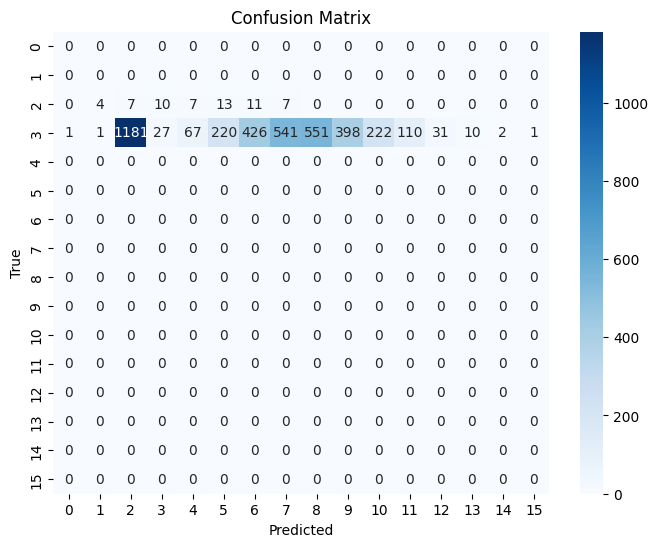

In [32]:
# 8. Оценка модели
print("Evaluating on Test Set...")
evaluate_model(model, test_loader)

Visualizing Predictions...


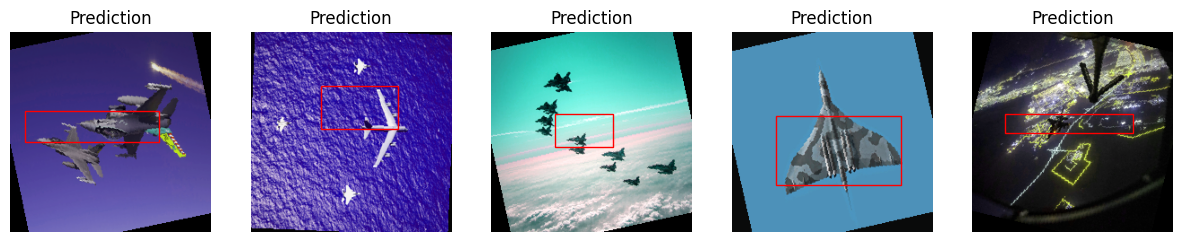

In [33]:
# 9. Визуализация ошибок
print("Visualizing Predictions...")
visualize_predictions(model, test_dataset, num_images=5)